# Clasificación de Pacientes

### Librerías y cargado de datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
SEED = 42

In [3]:
DATASET_PATH = os.path.join('..', 'datasets', 'subset_clasif.csv')
print(DATASET_PATH)

..\datasets\subset_clasif.csv


In [4]:
df = pd.read_csv(DATASET_PATH, encoding='latin', index_col=0, dtype='uint8')
df.head(3)

C:\Users\Sebastián\AppData\Roaming\Python\Python38\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,SEXO,PAC_HOSPITALIZADO,NEUMONIA,EDAD,EMBARAZO,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,DIAS_SINTOMAS,FALLECIDO
0,0,0,0,41,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,66,0,1,0,0,0,1,0,1,0,0,3,1
8,0,0,0,47,0,1,0,0,0,0,0,0,0,0,2,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 3667730 entries, 0 to 11
Data columns (total 16 columns):
 #   Column             Dtype
---  ------             -----
 0   SEXO               uint8
 1   PAC_HOSPITALIZADO  uint8
 2   NEUMONIA           uint8
 3   EDAD               uint8
 4   EMBARAZO           uint8
 5   DIABETES           uint8
 6   EPOC               uint8
 7   ASMA               uint8
 8   INMUSUPR           uint8
 9   HIPERTENSION       uint8
 10  CARDIOVASCULAR     uint8
 11  OBESIDAD           uint8
 12  RENAL_CRONICA      uint8
 13  TABAQUISMO         uint8
 14  DIAS_SINTOMAS      uint8
 15  FALLECIDO          uint8
dtypes: uint8(16)
memory usage: 83.9 MB


In [6]:
df_copy = df.copy()

## Preprocesamiento

### Tipado

In [91]:
y = df['FALLECIDO'].values.astype('float32')
X = df.drop(['FALLECIDO'], axis=1).values.astype('float32')

### Separación de Datos

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

### Muestreo

In [93]:
# 3.7 millones de registros
X.shape[0]

3667730

In [94]:
splitter = StratifiedShuffleSplit(n_splits=1, train_size=0.1, random_state=SEED)
indices = splitter.split(X, y)

In [95]:
for samples_idx, _ in indices:
    X_sampled = X[samples_idx]
    y_sampled = y[samples_idx]

In [96]:
# 370 mil registros
X_train.shape[0]

2934184

### Subsets de Entrenamiento y Prueba

In [97]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
indices = splitter.split(X_sampled, y_sampled)

In [98]:
for tr_idx, ts_idx in indices:
    X_train, X_test = X_sampled[tr_idx], X_sampled[ts_idx]
    y_train, y_test = y_sampled[tr_idx], y_sampled[ts_idx]

In [99]:
# Número de registros en cada subset
X_train.shape, X_test.shape

((293418, 15), (73355, 15))

#### Proporciones

In [102]:
count_normal = np.unique(y, return_counts=True)
count_tr = np.unique(y_train, return_counts=True)
count_ts = np.unique(y_test, return_counts=True)

Podemos comprobar que la proporción de clases se mantuvo en el dataset y los subsets

In [104]:
print('Proporción en los 3.7 millones de datos:', count_normal[1][0]/count_normal[1][1])
print('Proporción en el subset de entrenamiento:', count_tr[1][0]/count_tr[1][1])
print('Proporción en el subset de prueba:', count_ts[1][0]/count_ts[1][1])

Proporción en los 3.7 millones de datos: 12.313187850277318
Proporción en el subset de entrenamiento: 12.312976406533576
Proporción en el subset de prueba: 12.31306715063521


### Escalado de Datos

In [105]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [106]:
df.columns

Index(['SEXO', 'PAC_HOSPITALIZADO', 'NEUMONIA', 'EDAD', 'EMBARAZO', 'DIABETES',
       'EPOC', 'ASMA', 'INMUSUPR', 'HIPERTENSION', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'DIAS_SINTOMAS',
       'FALLECIDO'],
      dtype='object')

Rangos de las únicas variables discretas no binarias

In [107]:
# Edad
print(X_train[:,3].min(), X_train[:,3].max())
# Dias Sintomas
print(X_train[:,-1].min(), X_train[:,-1].max())

0.0 121.0
0.0 112.0


Vamos a escalar estas variables usando normalización, en parte porque no presentan una distribución normal y también porque de esa manera mantenemos similares el rango de todas las entradas de la red.

In [108]:
scaler = MinMaxScaler().fit(X_train[:,[3,-1]])
X_train[:,[3,-1]] = scaler.transform(X_train[:,[3,-1]])

Escalamos los datos de prueba usando los parámetros aprendidos en el subset de entrenamiento y el el dataset completo, ya que eso generaría contaminación de datos.

In [109]:
X_test[:,[3,-1]] = scaler.transform(X_test[:,[3,-1]])

## Modelado

### Modelo

In [116]:
import tensorflow as tf
from tensorflow import keras

In [117]:
# Para reproducibilidad
tf.random.set_seed(42)

In [118]:
model = keras.Sequential([
    keras.layers.Dense(30, activation='relu', input_shape=[15]),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

### Entrenamiento

In [120]:
TRAIN = True

In [121]:
if (TRAIN):
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
8253/8253 [==============================] - 29s 3ms/step - loss: 0.1297 - accuracy: 0.9298 - val_loss: 0.1237 - val_accuracy: 0.9360
Epoch 2/10
8253/8253 [==============================] - 24s 3ms/step - loss: 0.1231 - accuracy: 0.9368 - val_loss: 0.1224 - val_accuracy: 0.9319
Epoch 3/10
8253/8253 [==============================] - 23s 3ms/step - loss: 0.1223 - accuracy: 0.9367 - val_loss: 0.1226 - val_accuracy: 0.9365
Epoch 4/10
8253/8253 [==============================] - 23s 3ms/step - loss: 0.1222 - accuracy: 0.9374 - val_loss: 0.1232 - val_accuracy: 0.9319
Epoch 5/10
8253/8253 [==============================] - 23s 3ms/step - loss: 0.1224 - accuracy: 0.9365 - val_loss: 0.1208 - val_accuracy: 0.9356
Epoch 6/10
8253/8253 [==============================] - 26s 3ms/step - loss: 0.1230 - accuracy: 0.9368 - val_loss: 0.1255 - val_accuracy: 0.9370
Epoch 7/10
8253/8253 [==============================] - 22s 3ms/step - loss: 0.1223 - accuracy: 0.9378 - val_loss: 0.1221 - val_ac

In [200]:
model_path = os.path.join('..', 'results', 'model_clfn.tf')

In [201]:
# Salvar modelo e historia
if (TRAIN):
    model.save(model_path)
    history = history.history
    history_df = pd.DataFrame

INFO:tensorflow:Assets written to: ..\results\model_clfn.tf\assets


In [ ]:
if (!TRAIN):
    model = keras.models.load_model(model_path)
    history = pd.read_csv('..', 'results', 'history.csv')

### Evaluación

#### Curvas de aprendizaje

(0.9, 1.0)

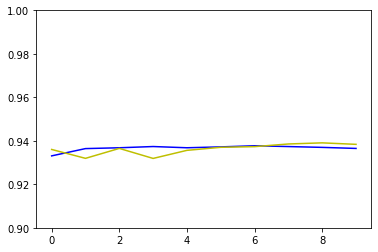

In [127]:
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'y')
plt.ylim([0.9,1.0])

### Accuracy y otras métricas

In [175]:
from sklearn.metrics import classification_report as cr
from sklearn.metrics import confusion_matrix as cm

In [189]:
probs = model.predict(X_test)

#### Con umbral=0.5

In [190]:
preds_50 = np.where(probs > 0.5, 1, 0)

In [191]:
results_50 = cr(y_test, preds_50)
print(results_50)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     67845
         1.0       0.60      0.51      0.55      5510

    accuracy                           0.94     73355
   macro avg       0.78      0.74      0.76     73355
weighted avg       0.93      0.94      0.94     73355



#### Con umbral=0.40

In [192]:
preds_40 = np.where(probs > 0.4, 1, 0)

In [193]:
results_40 = cr(y_test, preds_40)
print(results_40)

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     67845
         1.0       0.59      0.57      0.58      5510

    accuracy                           0.94     73355
   macro avg       0.78      0.77      0.77     73355
weighted avg       0.94      0.94      0.94     73355



#### Con umbral=0.30

In [194]:
preds_30 = np.where(probs > 0.3, 1, 0)

In [195]:
results_30 = cr(y_ts, preds_30)
print(results_30)

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     67845
         1.0       0.58      0.64      0.61      5510

    accuracy                           0.94     73355
   macro avg       0.77      0.80      0.79     73355
weighted avg       0.94      0.94      0.94     73355



#### Con umbral=0.2

In [196]:
preds_20 = np.where(probs > 0.2, 1, 0)

In [197]:
results_20 = cr(y_test, preds_20)
print(results_20)

              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     67845
         1.0       0.46      0.95      0.62      5510

    accuracy                           0.91     73355
   macro avg       0.73      0.93      0.79     73355
weighted avg       0.96      0.91      0.93     73355



### Distribución de las probabilidades

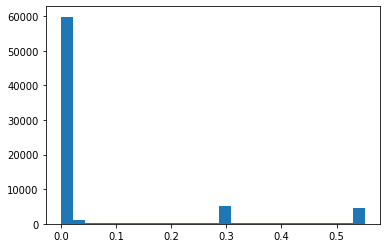

In [199]:
plt.hist(probs, bins=25)
plt.show()